Starting 5-year forecast analysis for Malawi...
🇲🇼 MALAWI NATIONAL 5-YEAR FORECASTING
Generating 5-year forecasts for Rainfall, NDVI, and LST...
Country-level data shape: (73, 3)
Time range: 2022-01-01 00:00:00 to 2025-02-18 00:00:00

📊 Forecasting Rainfall...


20:52:05 - cmdstanpy - INFO - Chain [1] start processing
20:52:06 - cmdstanpy - INFO - Chain [1] done processing
20:52:06 - cmdstanpy - INFO - Chain [1] start processing


🌿 Forecasting NDVI...


20:52:07 - cmdstanpy - INFO - Chain [1] done processing
20:52:07 - cmdstanpy - INFO - Chain [1] start processing


🌡️ Forecasting LST...


20:52:08 - cmdstanpy - INFO - Chain [1] done processing



📈 Generating comprehensive visualizations...


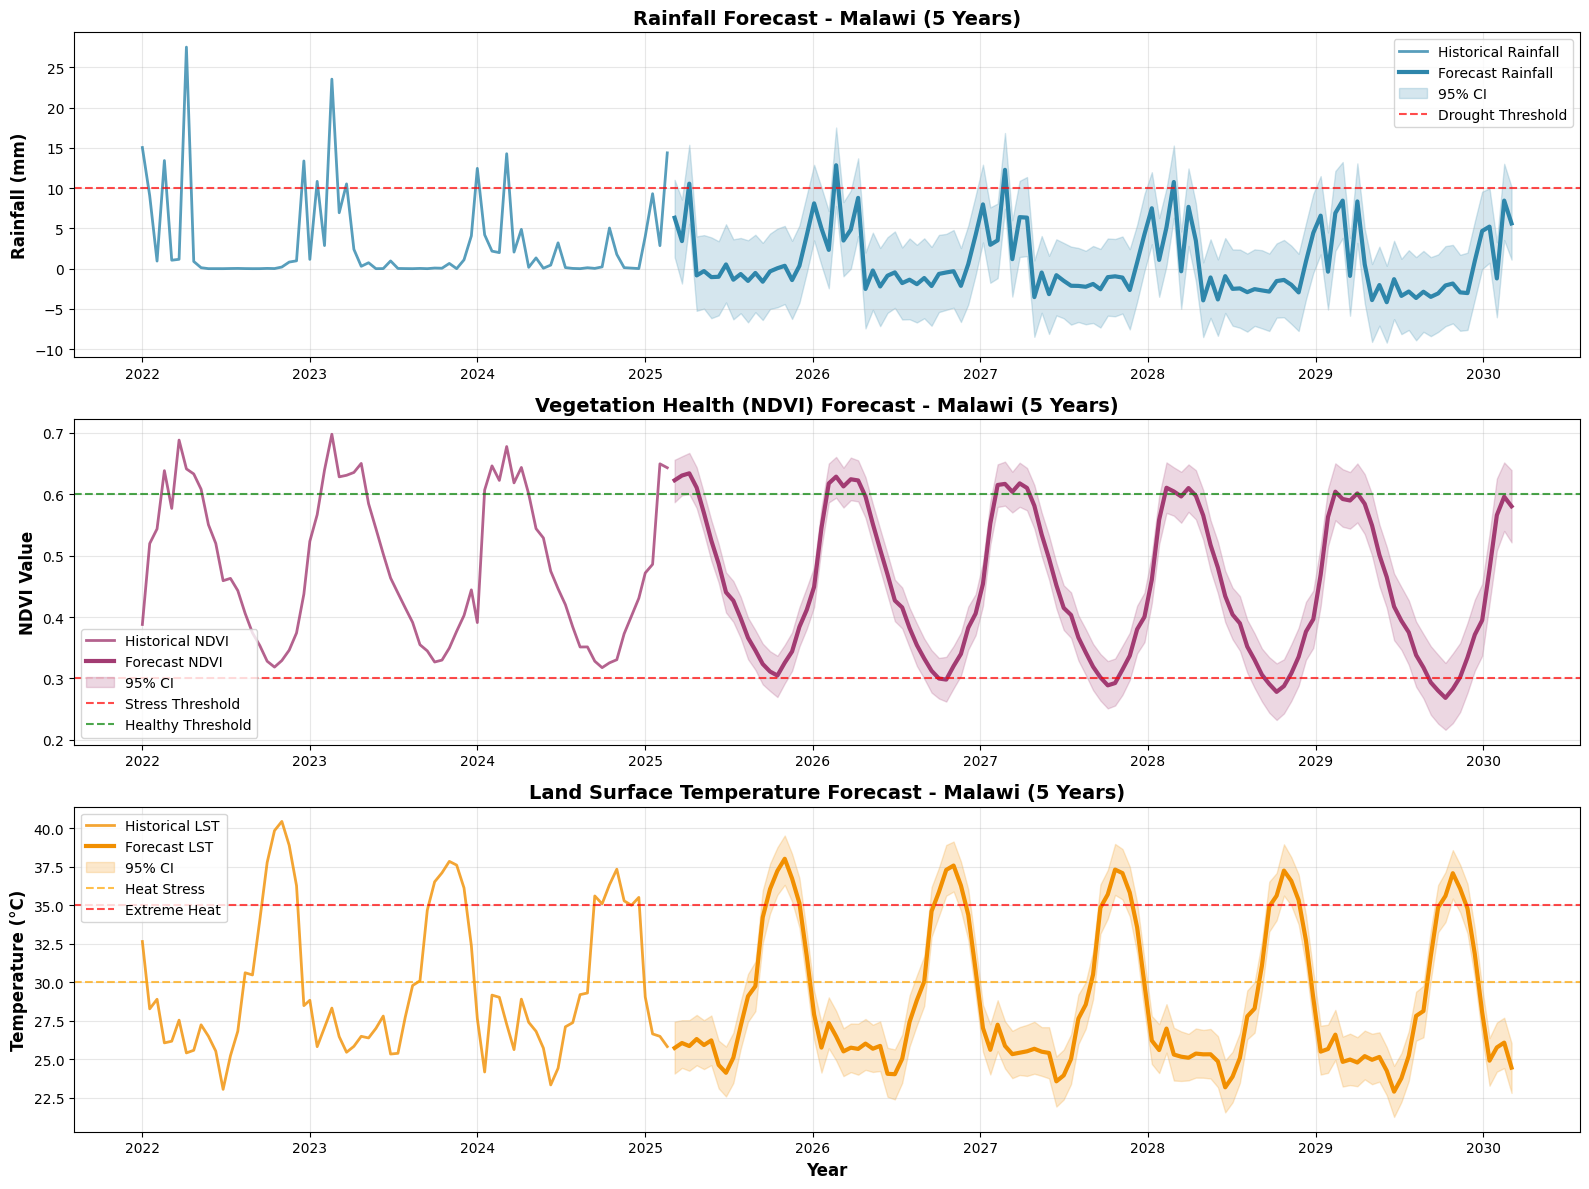

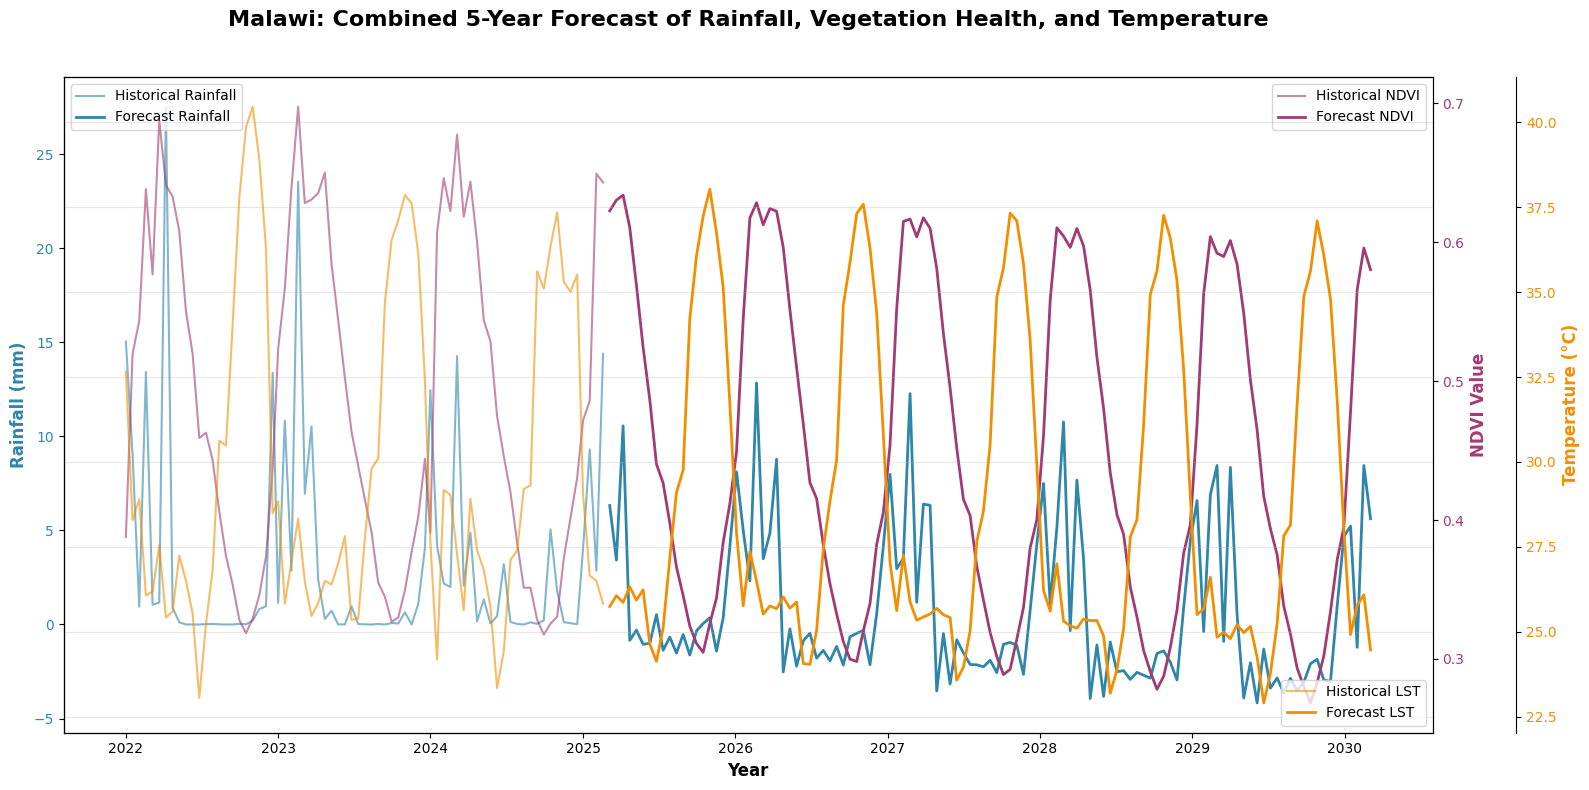

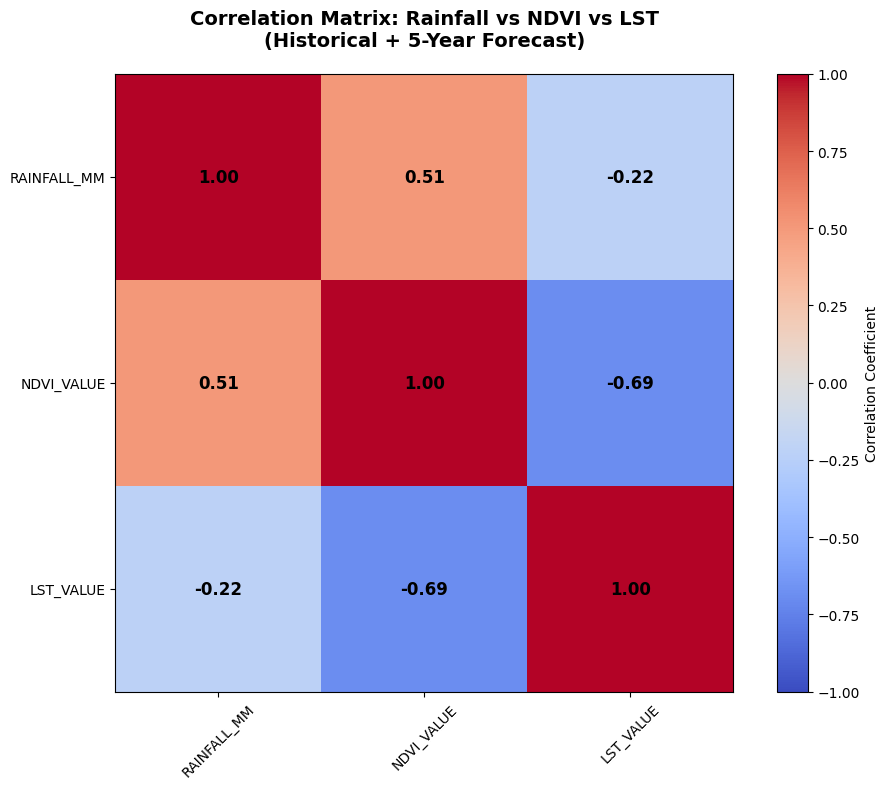

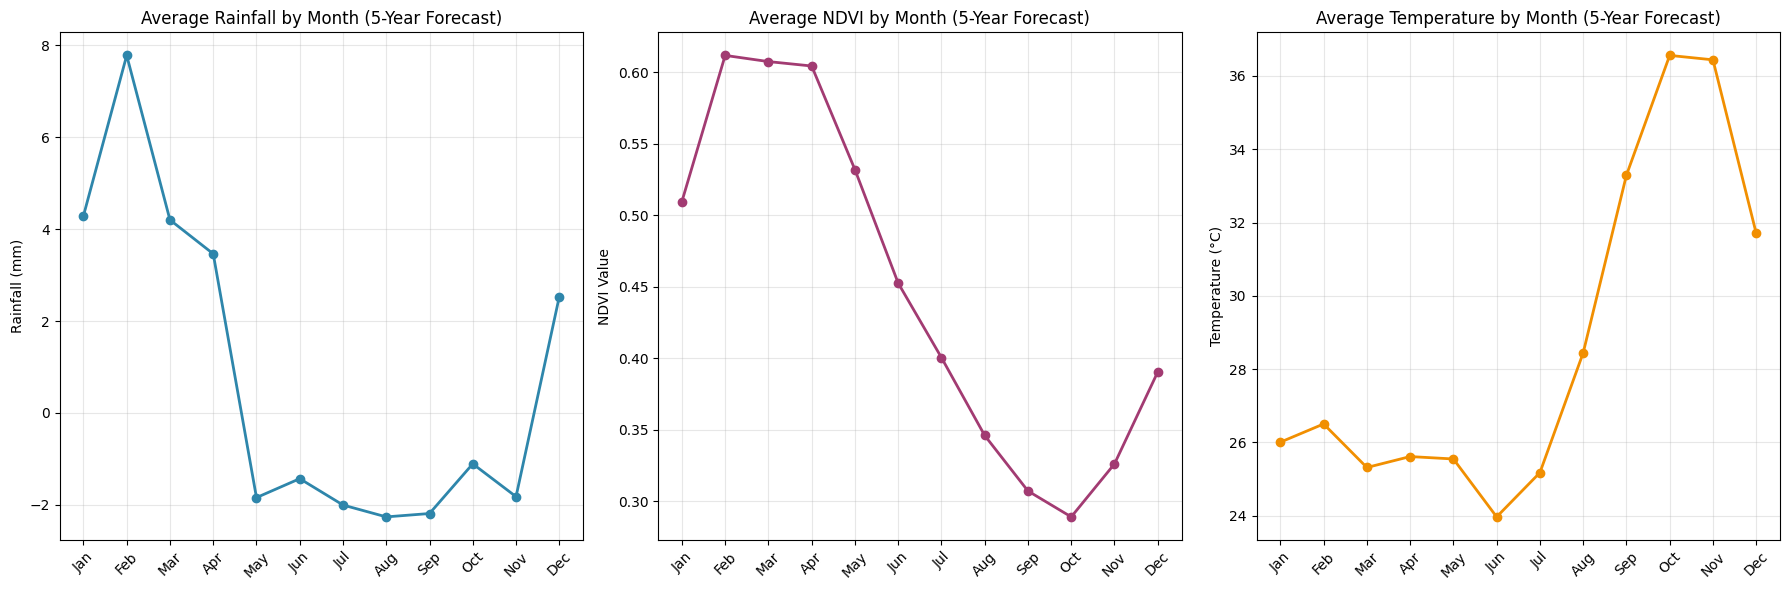


🇲🇼 MALAWI 5-YEAR FORECAST SUMMARY

📅 Forecast Period: 2025-03-06 to 2030-03-04
📊 Total forecast periods: 115

🌧️  Rainfall Forecast (5 Years):
   Annual Average: 0.7 mm
   Annual Range: -4.2 - 12.8 mm

🌿 NDVI Forecast (5 Years):
   Annual Average: 0.447
   Annual Range: 0.268 - 0.634

🌡️  Temperature Forecast (5 Years):
   Annual Average: 28.7°C
   Annual Range: 22.9 - 38.0°C

💾 Forecasts saved to 'malawi_5year_forecast.csv'

🎉 Forecast analysis complete! Check the generated visualizations:
   - Individual variable forecasts with confidence intervals
   - Combined chart with all three variables
   - Correlation heatmap between variables
   - Seasonal pattern analysis
   - CSV file with detailed forecast data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Load your data
combined_df = pd.read_csv('rainfall_ndvi_lst_cleaned.csv')
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])

def prepare_country_level_data(combined_df):
    """
    Aggregate data to country level by taking averages across all regions
    """
    # Group by date and calculate national averages
    country_data = combined_df.groupby('DATE').agg({
        'RAINFALL_MM': 'mean',
        'NDVI_VALUE': 'mean', 
        'LST_VALUE': 'mean'
    }).reset_index()
    
    country_data = country_data.sort_values('DATE').set_index('DATE')
    
    print(f"Country-level data shape: {country_data.shape}")
    print(f"Time range: {country_data.index.min()} to {country_data.index.max()}")
    
    return country_data

def prophet_forecast(series, periods=115, yearly_seasonality=True):
    """
    Use Facebook's Prophet for robust forecasting with seasonality
    """
    from prophet import Prophet
    
    # Prepare data for Prophet
    prophet_df = pd.DataFrame({
        'ds': series.index,
        'y': series.values
    })
    
    # Create and fit model
    model = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10
    )
    
    model.fit(prophet_df)
    
    # Create future dataframe (next 5 years with 16-day intervals)
    future = model.make_future_dataframe(periods=periods, freq='16D')
    forecast = model.predict(future)
    
    # Extract forecasted values
    forecast_series = forecast.set_index('ds')['yhat'][-periods:]
    confidence_lower = forecast.set_index('ds')['yhat_lower'][-periods:]
    confidence_upper = forecast.set_index('ds')['yhat_upper'][-periods:]
    
    return forecast_series, confidence_lower, confidence_upper

def plot_combined_forecasts(historical_data, forecasts, ci_dict=None):
    """
    Plot all three variables together for comprehensive analysis
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
    
    # Colors for each variable
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
    
    # 1. Rainfall Plot
    ax1.plot(historical_data.index, historical_data['RAINFALL_MM'], 
             label='Historical Rainfall', linewidth=2, color=colors[0], alpha=0.8)
    ax1.plot(forecasts.index, forecasts['RAINFALL_MM'], 
             label='Forecast Rainfall', linewidth=3, color=colors[0])
    
    if ci_dict and 'rainfall' in ci_dict:
        ax1.fill_between(forecasts.index, ci_dict['rainfall']['lower'], ci_dict['rainfall']['upper'],
                        color=colors[0], alpha=0.2, label='95% CI')
    
    ax1.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Drought Threshold')
    ax1.set_ylabel('Rainfall (mm)', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Rainfall Forecast - Malawi (5 Years)', fontsize=14, fontweight='bold')
    
    # 2. NDVI Plot
    ax2.plot(historical_data.index, historical_data['NDVI_VALUE'], 
             label='Historical NDVI', linewidth=2, color=colors[1], alpha=0.8)
    ax2.plot(forecasts.index, forecasts['NDVI_VALUE'], 
             label='Forecast NDVI', linewidth=3, color=colors[1])
    
    if ci_dict and 'ndvi' in ci_dict:
        ax2.fill_between(forecasts.index, ci_dict['ndvi']['lower'], ci_dict['ndvi']['upper'],
                        color=colors[1], alpha=0.2, label='95% CI')
    
    ax2.axhline(y=0.3, color='red', linestyle='--', alpha=0.7, label='Stress Threshold')
    ax2.axhline(y=0.6, color='green', linestyle='--', alpha=0.7, label='Healthy Threshold')
    ax2.set_ylabel('NDVI Value', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Vegetation Health (NDVI) Forecast - Malawi (5 Years)', fontsize=14, fontweight='bold')
    
    # 3. LST Plot
    ax3.plot(historical_data.index, historical_data['LST_VALUE'], 
             label='Historical LST', linewidth=2, color=colors[2], alpha=0.8)
    ax3.plot(forecasts.index, forecasts['LST_VALUE'], 
             label='Forecast LST', linewidth=3, color=colors[2])
    
    if ci_dict and 'lst' in ci_dict:
        ax3.fill_between(forecasts.index, ci_dict['lst']['lower'], ci_dict['lst']['upper'],
                        color=colors[2], alpha=0.2, label='95% CI')
    
    ax3.axhline(y=30, color='orange', linestyle='--', alpha=0.7, label='Heat Stress')
    ax3.axhline(y=35, color='red', linestyle='--', alpha=0.7, label='Extreme Heat')
    ax3.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Land Surface Temperature Forecast - Malawi (5 Years)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_combined_single_chart(historical_data, forecasts):
    """
    Plot all three variables on one chart with multiple y-axes
    """
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    # Plot Rainfall (left axis)
    color1 = '#2E86AB'
    ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Rainfall (mm)', color=color1, fontsize=12, fontweight='bold')
    ax1.plot(historical_data.index, historical_data['RAINFALL_MM'], 
             color=color1, alpha=0.6, label='Historical Rainfall')
    ax1.plot(forecasts.index, forecasts['RAINFALL_MM'], 
             color=color1, linewidth=2, label='Forecast Rainfall')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.legend(loc='upper left')
    
    # Plot NDVI (right axis 1)
    ax2 = ax1.twinx()
    color2 = '#A23B72'
    ax2.set_ylabel('NDVI Value', color=color2, fontsize=12, fontweight='bold')
    ax2.plot(historical_data.index, historical_data['NDVI_VALUE'], 
             color=color2, alpha=0.6, label='Historical NDVI')
    ax2.plot(forecasts.index, forecasts['NDVI_VALUE'], 
             color=color2, linewidth=2, label='Forecast NDVI')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc='upper right')
    
    # Plot LST (right axis 2)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    color3 = '#F18F01'
    ax3.set_ylabel('Temperature (°C)', color=color3, fontsize=12, fontweight='bold')
    ax3.plot(historical_data.index, historical_data['LST_VALUE'], 
             color=color3, alpha=0.6, label='Historical LST')
    ax3.plot(forecasts.index, forecasts['LST_VALUE'], 
             color=color3, linewidth=2, label='Forecast LST')
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.legend(loc='lower right')
    
    plt.title('Malawi: Combined 5-Year Forecast of Rainfall, Vegetation Health, and Temperature\n', 
             fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(historical_data, forecasts):
    """
    Plot correlation heatmap between the three variables
    """
    # Combine historical and forecast data
    combined = pd.concat([historical_data, forecasts])
    
    # Calculate correlation matrix
    corr_matrix = combined.corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    
    # Add correlation values
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                    ha='center', va='center', fontweight='bold', fontsize=12)
    
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.colorbar(im, label='Correlation Coefficient')
    plt.title('Correlation Matrix: Rainfall vs NDVI vs LST\n(Historical + 5-Year Forecast)', 
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def plot_seasonal_decomposition(forecasts):
    """
    Plot seasonal patterns in the 5-year forecast
    """
    forecasts['year'] = forecasts.index.year
    forecasts['month'] = forecasts.index.month
    
    # Seasonal analysis by month
    monthly_avg = forecasts.groupby('month').mean()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Rainfall seasonality
    axes[0].plot(months, monthly_avg['RAINFALL_MM'], marker='o', linewidth=2, color='#2E86AB')
    axes[0].set_title('Average Rainfall by Month (5-Year Forecast)')
    axes[0].set_ylabel('Rainfall (mm)')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # NDVI seasonality
    axes[1].plot(months, monthly_avg['NDVI_VALUE'], marker='o', linewidth=2, color='#A23B72')
    axes[1].set_title('Average NDVI by Month (5-Year Forecast)')
    axes[1].set_ylabel('NDVI Value')
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    # LST seasonality
    axes[2].plot(months, monthly_avg['LST_VALUE'], marker='o', linewidth=2, color='#F18F01')
    axes[2].set_title('Average Temperature by Month (5-Year Forecast)')
    axes[2].set_ylabel('Temperature (°C)')
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return monthly_avg

def forecast_malawi_5years():
    """
    Main function to forecast all three variables for Malawi for next 5 years
    """
    print("🇲🇼 MALAWI NATIONAL 5-YEAR FORECASTING")
    print("="*60)
    print("Generating 5-year forecasts for Rainfall, NDVI, and LST...")
    
    # Prepare country-level data
    country_data = prepare_country_level_data(combined_df)
    
    # Calculate periods for 5 years (365*5/16 ≈ 115 periods)
    periods = 115
    
    # Forecast each variable using Prophet
    print("\n📊 Forecasting Rainfall...")
    rainfall_forecast, rain_lower, rain_upper = prophet_forecast(
        country_data['RAINFALL_MM'], periods
    )
    
    print("🌿 Forecasting NDVI...")
    ndvi_forecast, ndvi_lower, ndvi_upper = prophet_forecast(
        country_data['NDVI_VALUE'], periods
    )
    
    print("🌡️ Forecasting LST...")
    lst_forecast, lst_lower, lst_upper = prophet_forecast(
        country_data['LST_VALUE'], periods
    )
    
    # Create forecast DataFrame
    prophet_forecasts = pd.DataFrame({
        'RAINFALL_MM': rainfall_forecast.values,
        'NDVI_VALUE': ndvi_forecast.values,
        'LST_VALUE': lst_forecast.values
    }, index=rainfall_forecast.index)
    
    # Confidence intervals dictionary
    ci_dict = {
        'rainfall': {'lower': rain_lower, 'upper': rain_upper},
        'ndvi': {'lower': ndvi_lower, 'upper': ndvi_upper},
        'lst': {'lower': lst_lower, 'upper': lst_upper}
    }
    
    # Generate all plots
    print("\n📈 Generating comprehensive visualizations...")
    
    # 1. Individual subplots
    plot_combined_forecasts(country_data, prophet_forecasts, ci_dict)
    
    # 2. Combined single chart
    plot_combined_single_chart(country_data, prophet_forecasts)
    
    # 3. Correlation heatmap
    plot_correlation_heatmap(country_data, prophet_forecasts)
    
    # 4. Seasonal decomposition
    monthly_avg = plot_seasonal_decomposition(prophet_forecasts)
    
    # Print comprehensive summary
    print("\n" + "="*60)
    print("🇲🇼 MALAWI 5-YEAR FORECAST SUMMARY")
    print("="*60)
    
    print(f"\n📅 Forecast Period: {prophet_forecasts.index[0].strftime('%Y-%m-%d')} to {prophet_forecasts.index[-1].strftime('%Y-%m-%d')}")
    print(f"📊 Total forecast periods: {len(prophet_forecasts)}")
    
    print(f"\n🌧️  Rainfall Forecast (5 Years):")
    print(f"   Annual Average: {prophet_forecasts['RAINFALL_MM'].mean():.1f} mm")
    print(f"   Annual Range: {prophet_forecasts['RAINFALL_MM'].min():.1f} - {prophet_forecasts['RAINFALL_MM'].max():.1f} mm")
    
    print(f"\n🌿 NDVI Forecast (5 Years):")
    print(f"   Annual Average: {prophet_forecasts['NDVI_VALUE'].mean():.3f}")
    print(f"   Annual Range: {prophet_forecasts['NDVI_VALUE'].min():.3f} - {prophet_forecasts['NDVI_VALUE'].max():.3f}")
    
    print(f"\n🌡️  Temperature Forecast (5 Years):")
    print(f"   Annual Average: {prophet_forecasts['LST_VALUE'].mean():.1f}°C")
    print(f"   Annual Range: {prophet_forecasts['LST_VALUE'].min():.1f} - {prophet_forecasts['LST_VALUE'].max():.1f}°C")
    
    # Save forecasts to CSV
    prophet_forecasts.to_csv('malawi_5year_forecast.csv')
    print(f"\n💾 Forecasts saved to 'malawi_5year_forecast.csv'")
    
    return {
        'historical_data': country_data,
        'forecasts': prophet_forecasts,
        'confidence_intervals': ci_dict,
        'monthly_averages': monthly_avg
    }

# Run the 5-year forecasting
print("Starting 5-year forecast analysis for Malawi...")
malawi_5year_forecast = forecast_malawi_5years()

print("\n🎉 Forecast analysis complete! Check the generated visualizations:")
print("   - Individual variable forecasts with confidence intervals")
print("   - Combined chart with all three variables")
print("   - Correlation heatmap between variables")
print("   - Seasonal pattern analysis")
print("   - CSV file with detailed forecast data")